<a href="https://colab.research.google.com/github/jingxlim/course-content/blob/interactive-track/projects/steinmetz_dimred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='Processing...')
from analysis_toolbox.utils import *

## Loading of Steinmetz data

includes some visualizations

In [3]:
import os, requests
import socket

fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
    
print(fname)

['steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz']


In [4]:
#@title Data retrieval
if socket.gethostname() == 'ahrensm-ws2':
    # download unncessary, just reload data
    root_dir = '/nrs/ahrens/jing/steinmetz_decision/'
    ana_path = root_dir + 'analysis/'
    fname = [root_dir+name for name in fname]
    print(fname)
    
else:  # if on Google Colab or an as yet undefined location
    
    url = ["https://osf.io/agvxh/download"]
    url.append("https://osf.io/uv3mw/download")
    url.append("https://osf.io/ehmw2/download")

    for j in range(len(url)):
        if not os.path.isfile(fname[j]):
            try:
                r = requests.get(url[j])
            except requests.ConnectionError:
                print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)

['/nrs/ahrens/jing/steinmetz_decision/steinmetz_part0.npz', '/nrs/ahrens/jing/steinmetz_decision/steinmetz_part1.npz', '/nrs/ahrens/jing/steinmetz_decision/steinmetz_part2.npz']


In [5]:
#@title Data loading
import numpy as np

alldat = np.array([])
for name in fname:
    alldat = np.hstack((alldat, np.load(name, allow_pickle=True)['dat']))

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [24]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
colors = ['tab:blue', 'tab:orange', 'tab:green',
          'tab:red', 'tab:purple', 'tab:brown',
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

if socket.gethostname() == 'ahrensm-ws2':
    pass
else:
    rcParams['figure.figsize'] = [20, 4]
    rcParams['font.size'] =15

In [94]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
session_id = 36 ## midbrain 23, 36
dat = alldat[session_id]

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [95]:
#@title print shapes of data
def dict_contents(dat):
    for k in dat.keys():
        print(f"dat['{k}']", end=' ')
        if isinstance(dat[k], np.ndarray):
            print(dat[k].shape)
        else:
            print(dat[k])
            
dict_contents(dat)

dat['spks'] (1055, 181, 250)
dat['wheel'] (1, 181, 250)
dat['pupil'] (3, 181, 250)
dat['lfp'] (8, 181, 250)
dat['response'] (181,)
dat['response_time'] (181, 1)
dat['bin_size'] 0.01
dat['stim_onset'] 0.5
dat['contrast_right'] (181,)
dat['contrast_left'] (181,)
dat['brain_area'] (1055,)
dat['brain_area_lfp'] ['MOs', 'ORB', 'PAG', 'RSP', 'SCm', 'SCs', 'MB', 'VISam']
dat['feedback_time'] (181, 1)
dat['feedback_type'] (181,)
dat['gocue'] (181, 1)
dat['mouse_name'] Tatum
dat['date_exp'] 2017-12-08
dat['trough_to_peak'] (1055,)
dat['waveform_w'] (1055, 82, 3)
dat['waveform_u'] (1055, 3, 384)
dat['active_trials'] (291,)
dat['contrast_left_passive'] (110,)
dat['contrast_right_passive'] (110,)
dat['spks_passive'] (1055, 110, 250)
dat['lfp_passive'] (8, 110, 250)
dat['pupil_passive'] (3, 110, 250)
dat['wheel_passive'] (1, 110, 250)


In [96]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [97]:
brain_areas, brain_areas_count = np.unique(dat['brain_area'], return_counts=True)
brain_areas_color = np.full(brain_areas.shape, np.nan)
brain_areas_labels = []

for i, brain_area in enumerate(brain_areas):  # if brain area is in brain group
    for j, brain_group in enumerate(brain_groups):
        if brain_area in brain_group:
            brain_areas_color[i] = j # assign a number to each region
            brain_areas_labels.append(regions[j])

print(brain_areas_labels)
brain_areas_color += 1  ##
brain_areas_color = np.nan_to_num(brain_areas_color)
brain_areas_color = [colors[int(color)] for color in brain_areas_color]

## Find the labels for the different brain regions
print(brain_areas_labels, brain_areas_color)

unique_labels = np.unique(brain_areas_labels)
unique_colors = []
for i, unique_label in enumerate(unique_labels):
    color_ind = np.where(np.array(brain_areas_labels) == unique_label)[0][0]
    color = brain_areas_color[color_ind]
    unique_colors.append(color)
    
print(unique_labels, unique_colors)
    
plt.figure()
plt.bar(brain_areas, brain_areas_count, color=brain_areas_color)

handles = [plt.Rectangle((0,0),1,1, color=unique_color) for unique_color in unique_colors]
plt.legend(handles, unique_labels)
plt.ylabel('num(neurons)')
plt.xlabel('brain regions')

plt.savefig(ana_path + f'brain-regions_ses-{session_id}' + now_str() +'.png')

['midbrain', 'other ctx', 'other ctx', 'midbrain', 'other ctx', 'midbrain', 'midbrain', 'vis ctx']
['midbrain', 'other ctx', 'other ctx', 'midbrain', 'other ctx', 'midbrain', 'midbrain', 'vis ctx'] ['tab:brown', 'tab:purple', 'tab:purple', 'tab:brown', 'tab:purple', 'tab:brown', 'tab:brown', 'tab:orange', 'tab:blue']
['midbrain' 'other ctx' 'vis ctx'] ['tab:brown', 'tab:purple', 'tab:orange']


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


FigureCanvasNbAgg()

In [84]:
nareas = len(regions) - 2 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other" (i.e. default is 4); "other" is not the same as "other ctx"

for j in range(nareas):  # if brain area is in brain group
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

### Have a look at trial difficulty

In [58]:
difficulty = np.abs(dat['contrast_right'] - dat['contrast_left'])
difficulty.shape

(340,)

(array([126.,   0.,  49.,   0.,   0.,  65.,   0.,  44.,   0.,  56.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

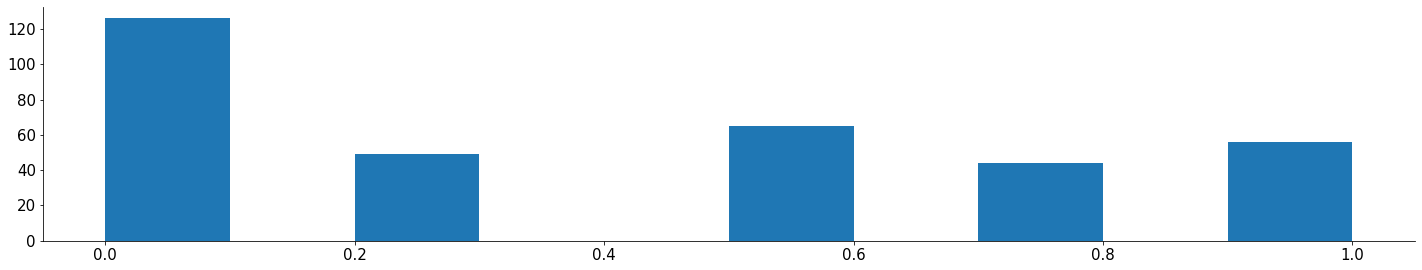

In [59]:
plt.figure()
plt.hist(difficulty)

Text(0.5, 1.0, 'feedback time')

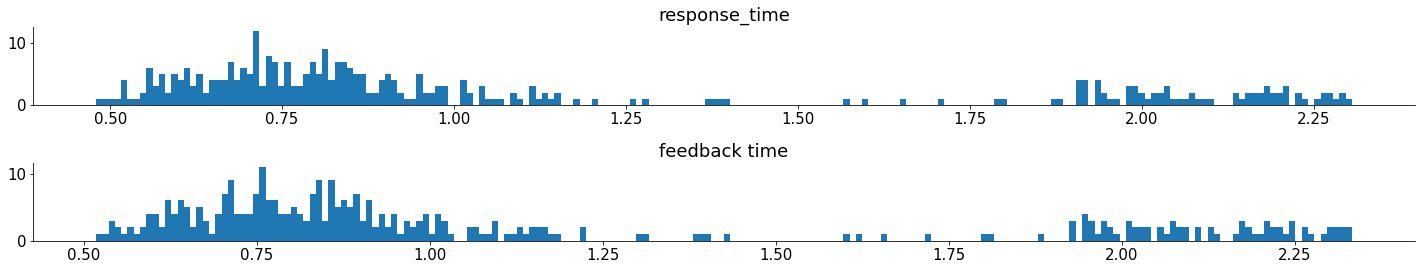

In [57]:
fig, ax = plt.subplots(2,1)
ax[0].hist(dat['response_time'], bins=200)
ax[0].set_title('response_time')
ax[1].hist(dat['feedback_time'], bins=200)
ax[1].set_title('feedback time')

In [9]:
def bin_midpoints(dt, NT):
    """
    dt [float]: bin size in ms
    NT [int]: number of time bins
    """
    edges = dt * np.arange(NT+1)
    
    return (edges[1:] + edges[:-1]) / 2

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]
trial_taxis = bin_midpoints(dt, NT)

### Summary plots of population average and region average

In [86]:
# Basic plots of population average
fig, ax = plt.subplots(1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high

# categorize by response type, and take mean over both neurons (all types) and trials
ax.plot(trial_taxis, 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
ax.plot(trial_taxis, 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
ax.plot(trial_taxis, 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
ax.plot(trial_taxis, 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

ax.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


FigureCanvasNbAgg()

In [261]:
## if I'm only interested in neurons from a certain brain region
visctx_dat = dat.copy()
for key, value in visctx_dat.items():
    if isinstance(value, np.ndarray):
        if value.shape[0] == NN:
            visctx_dat[key] = value[barea == 0]

In [18]:
# Plots by brain region and visual conditions
plt.figure(figsize=(10, 3))
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)

    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
    plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1))) 
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])

FigureCanvasNbAgg()

In [19]:
# Plots by brain region and response type
plt.figure(figsize=(10, 3))
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    plt.title(regions[j])
    if np.sum(barea==j)==0: continue
    plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
    plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))

    if j==0: plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
    ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')

FigureCanvasNbAgg()

### Perform dimensionality reduction

In [71]:
# Top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

def PCA_and_proj(X, X_proj, n_components):
    """Run PCA on concatenated trials
    X [np.array]: [neurons, trials, time]
                  the array to run PCA on
    X_proj [np.array]: [neurons, trials, time]
                       Project this array onto the PCs. Must have the same number of neurons as X.
    n_components [int]: number of PCs
    """
    ## trial PCA model on trials, not trial mean
    droll = np.reshape(X, (len(X),-1)) # first 80 bins = 1.6 sec
    droll  = droll - np.mean(droll, axis=1, keepdims=True)
    model = PCA(n_components = n_components).fit(droll.T)

    W = model.components_
    pc = W @ np.reshape(X_proj, (len(X_proj),-1))  ## project spikes onto low dim space; PC x neurons @ neurons x (trial x trial time)
    pc = np.reshape(pc, (n_components, -1, NT))  ## reshape back into trial structure
    
    return model, pc

def plot_variance_explained(model, figax=None, label=''):
    
    from matplotlib.ticker import MaxNLocator, PercentFormatter

    if figax is None: fig, ax = plt.subplots(figsize=(4,3))
    else:
        fig, ax = figax

    ax.plot(np.arange(1, model.n_components_+1), model.explained_variance_, label=label)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_xlabel('PCs')
    ax.set_ylabel('Cumulative variance explained')
    fig.tight_layout()
    
    return fig, ax

# The top PCs capture most variance across the brain. What do they care about? 

def visualize_pcs(PCs, vis_left, vis_right, response):
    """
    PCs [numpy.array]: [PCs, trials, time]
    
    """
    
    fig = plt.figure(figsize= (4*len(PCs), 6))
    axes = []  ## collect axes
    for j in range(len(PCs)):  ## for each PC

        ax = plt.subplot(2,len(PCs)+1,j+1)
        pc = PCs[j]

        plt.plot(pc[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
        plt.plot(pc[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
        plt.plot(pc[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
        plt.plot(pc[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))

        if j==0: plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
        plt.title('PC %d'%j)

        ax = plt.subplot(2,len(PCs)+1,len(PCs)+1 + j+1)

        plt.plot(pc[response>0, :].mean(axis=0))  
        plt.plot(pc[response<0, :].mean(axis=0))
        plt.plot(pc[response==0, :].mean(axis=0))

        if j==0: plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
        ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
        plt.title('PC %d'%j)
        
        axes.append(ax)
        
    return fig, axes

In [269]:
## example from the original notebook
model, pc_10ms = PCA_and_proj(dat['spks'][:,:,51:130], dat['spks'], 10)
print(pc_10ms.shape)
plot_variance_explained(model)
pc10ms_fig, pc10ms_ax = visualize_pcs(pc_10ms, vis_left, vis_right, response)

(10, 340, 250)


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


FigureCanvasNbAgg()

(<Figure size 400x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca5cbe6dd8>)

In [140]:
midbrain_model.components_.shape

(10, 535)

In [276]:
## run PCA on a subset of cells
visctx_model, visctx_pc = PCA_and_proj(visctx_dat['spks'][:,:,51:130], visctx_dat['spks'], 10)
print(visctx_pc.shape)
plot_variance_explained(visctx_model)
visctx_fig, visctx_ax = visualize_pcs(visctx_pc, vis_left, vis_right, response)

(10, 340, 250)


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


FigureCanvasNbAgg()

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


FigureCanvasNbAgg()

In [227]:
def generate_indices(event_times, before, after, dt):
    """
    event_times [numpy.array]: 1d array of event times to align to
    """
    window = np.arange(before, after, dt)
    indices = event_times[:, np.newaxis] +  window[:, np.newaxis].T
    return window, indices

In [228]:
# Align neural responses to (1) presentation of visual stimulus, (2) behavioural response, (3) feedback presentation
# 1) dat['stim_onset']
# 2) dat['response_time']
# 3) dat['feedback_time']
NTr = dat['spks'].shape[1]
stim_align_win, stim_align_ind = generate_indices(np.tile(dat['stim_onset'], NTr), -0.1, 0.3, dt)
resp_align_win, resp_align_ind = generate_indices(np.squeeze(dat['response_time']), -0.2, 0.1, dt)
feed_align_win, feed_align_ind = generate_indices(np.squeeze(dat['feedback_time']), -0.1, 0.15, dt)

In [103]:
## interpolate spikes in preparation for alignment
from scipy import interpolate
spks_interp = interpolate.interp1d(trial_taxis, dat['spks'])
stim_align = spks_interp(stim_align_ind[0])
print(stim_align.shape)

(698, 340, 40)

In [123]:
def interpolate_trials(t, y, inds):
    """
    t [np.array]: [time]
                  1d array of time points
    y [np.array]: [neurons, trials, time]
    inds [np.array]: [trials, time]
    """
    all_trials = []
    for tr, ind in enumerate(tqdm(inds)):
        interp = interpolate.interp1d(t, y[:, tr, :])
        all_trials.append(interp(ind))
    return np.swapaxes(np.stack(all_trials),0,1)

In [124]:
resp_align = interpolate_trials(trial_taxis, dat['spks'], resp_align_ind)
feed_align = interpolate_trials(trial_taxis, dat['spks'], feed_align_ind)

In [224]:
from rastermap import Rastermap
def smooth_raster(raster, space=None, time=None):
    
    from scipy.ndimage import gaussian_filter1d
    
    if space: raster = gaussian_filter1d(raster, space, axis=0)
    if time: raster = gaussian_filter1d(raster, time, axis=1)
        
    return raster

In [248]:
def rastermap_and_plot(raster, t_axis):
    zscored = np.nan_to_num(zscore(raster,axis=1))
    print(zscored.shape)
    rm = Rastermap(n_components=2,n_X=40,nPC=10).fit(zscored)
    
    fig, ax = plt.subplots()
    ax.imshow(smooth_raster(zscored[rm.isort], time=1), aspect='auto', cmap='viridis',
               extent=[t_axis[0],t_axis[-1], 0, zscored.shape[0]])
    ax.axvline(x=0, color='k', linestyle='--')
    
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('neurons')
    
    return fig, ax

In [249]:
stim_rm_fig, stim_rm_ax = rastermap_and_plot(np.nanmean(stim_align, axis=1),stim_align_win)
resp_rm_fig, resp_rm_ax = rastermap_and_plot(np.nanmean(resp_align, axis=1),resp_align_win)
feed_rm_fig, feed_rm_ax = rastermap_and_plot(np.nanmean(feed_align, axis=1),feed_align_win)

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(698, 40)
nmin 10
(1520, 1600)
(70,)
1.0
time; iteration;  explained PC variance
0.04s     0        0.5732      8
0.46s    10        0.7371      24
0.87s    20        0.8162      80
1.37s    30        0.8622      360
2.15s    40        0.9117      840
3.36s    50        0.9647      1520
4.84s    60        0.9670      1520
6.18s   final      0.9680
13.28s upsampled    0.9680


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


FigureCanvasNbAgg()

(698, 31)
nmin 10
(1520, 1600)
(70,)
1.0
time; iteration;  explained PC variance
0.05s     0        0.4532      8


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


0.53s    10        0.6347      24
1.02s    20        0.7481      80
1.59s    30        0.8229      360
2.47s    40        0.8887      840
3.80s    50        0.9662      1520
5.45s    60        0.9674      1520
6.90s   final      0.9665
13.99s upsampled    0.9665


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


FigureCanvasNbAgg()

(698, 25)
nmin 10
(1520, 1600)
(70,)
1.0
time; iteration;  explained PC variance
0.04s     0        0.4279      8


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


0.47s    10        0.5996      24
0.88s    20        0.7235      80
1.39s    30        0.8092      360
2.17s    40        0.8792      840
3.39s    50        0.9662      1520
4.90s    60        0.9681      1520
6.24s   final      0.9710
13.32s upsampled    0.9710


/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


FigureCanvasNbAgg()

In [250]:
stim_rm_ax.set_title('Stimulus aligned')
stim_rm_fig.savefig(ana_path + 'stim-aligned-raster_' + now_str() + '.png')

resp_rm_ax.set_title('Response aligned')
resp_rm_fig.savefig(ana_path + 'resp-aligned-raster_' + now_str() + '.png')

feed_rm_ax.set_title('Feedback aligned')
feed_rm_fig.savefig(ana_path + 'feed-aligned-raster_' + now_str() + '.png')

In [ ]:
stim_model, stim_pc = PCA_and_proj(stim_align, 10)
resp_model, resp_pc = PCA_and_proj(resp_align, 10)
feed_model, feed_pc = PCA_and_proj(feed_align, 10)

ve_fig, ve_ax = plt.subplots(1,3,figsize=(10,3))
stim_fig, stim_ax = plot_variance_explained(stim_model, figax=(ve_fig, ve_ax[0]))
resp_fig, resp_ax = plot_variance_explained(resp_model, figax=(ve_fig, ve_ax[1]))
feed_fig, feed_ax = plot_variance_explained(feed_model, figax=(ve_fig, ve_ax[2]))

for ax in ve_ax:
    ax.set_ylim(top=np.nanmax(np.concatenate((stim_model.explained_variance_,
                                              resp_model.explained_variance_,
                                              feed_model.explained_variance_)))*1.1)

In [174]:
stimpc_fig, stimpc_ax = visualize_pcs(stim_pc, vis_left, vis_right, response)
stimpc_fig.suptitle('stim aligned')
stimpc_fig.tight_layout(rect=[0, 0.03, 1, 0.90])
stimpc_fig.savefig(ana_path + 'vis-pcs_stim_' + now_str() + '.png')

resppc_fig, resppc_ax = visualize_pcs(resp_pc, vis_left, vis_right, response)
resppc_fig.suptitle('response aligned')
resppc_fig.tight_layout(rect=[0, 0.03, 1, 0.90])
resppc_fig.savefig(ana_path + 'vis-pcs_resp_' + now_str() + '.png')

feedpc_fig, feedpc_ax = visualize_pcs(feed_pc, vis_left, vis_right, response)
feedpc_fig.suptitle('feedback aligned')
feedpc_fig.tight_layout(rect=[0, 0.03, 1, 0.90])
feedpc_fig.savefig(ana_path + 'vis-pcs_feed_' + now_str() + '.png')

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


FigureCanvasNbAgg()

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


FigureCanvasNbAgg()

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


FigureCanvasNbAgg()

In [164]:
vex_fig, vex_ax = plt.subplots(1,1,figsize=(4,4))
plot_variance_explained(stim_model, figax=(vex_fig, vex_ax), label='stim')
plot_variance_explained(resp_model, figax=(vex_fig, vex_ax), label='response')
plot_variance_explained(feed_model, figax=(vex_fig, vex_ax), label='feedback')
vex_ax.legend()
vex_ax.set_title('Aligned to events')
vex_fig.savefig(ana_path + 'var-exp_' + now_str() + '.png')

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


FigureCanvasNbAgg()

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for j in range(nareas):
    ax.scatter(W[0][barea==j],
              W[1][barea==j],
              W[2][barea==j],
              s=1,
              c=colors[j],
              label=regions[j])
plt.legend()
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.tight_layout()

FigureCanvasNbAgg()

### Look into individual areas

In [98]:
midbrain_model, midbrain_pcs = PCA_and_proj(dat['spks'][barea==4,:,51:130], dat['spks'][barea==4], 10)
plot_variance_explained(midbrain_model)
midbrain_fig, midbrain_ax = visualize_pcs(midbrain_pcs, dat['contrast_left'], dat['contrast_right'], dat['response'])
midbrain_fig.suptitle('stim aligned')
midbrain_fig.tight_layout(rect=[0, 0.03, 1, 0.90])
midbrain_fig.savefig(ana_path + f'midbrain-pcs_stim_ses-{session_id}_' + now_str() + '.png')

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


FigureCanvasNbAgg()

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


FigureCanvasNbAgg()

In [100]:
brain_groups

[['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl'],
 ['CL',
  'LD',
  'LGd',
  'LH',
  'LP',
  'MD',
  'MG',
  'PO',
  'POL',
  'PT',
  'RT',
  'SPF',
  'TH',
  'VAL',
  'VPL',
  'VPM'],
 ['CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST'],
 ['ACA',
  'AUD',
  'COA',
  'DP',
  'ILA',
  'MOp',
  'MOs',
  'OLF',
  'ORB',
  'ORBm',
  'PIR',
  'PL',
  'SSp',
  'SSs',
  'RSP',
  ' TT'],
 ['APN',
  'IC',
  'MB',
  'MRN',
  'NB',
  'PAG',
  'RN',
  'SCs',
  'SCm',
  'SCig',
  'SCsg',
  'ZI'],
 ['ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI'],
 ['BLA', 'BMA', 'EP', 'EPd', 'MEA']]

In [113]:
midbrain_model.components_[0].shape

(535,)

In [114]:
print(brain_groups[4])

['APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI']


In [110]:
midbrain_model.components_[0][dat['brain_area'][barea==4]==j]

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


array([], shape=(0, 535), dtype=float64)

In [133]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for j, brain_group in enumerate(brain_groups[4]):
    print(brain_group)
    print((j%len(colors)-1))
    ax.scatter(midbrain_model.components_[0][dat['brain_area'][barea==4]==brain_group],
              midbrain_model.components_[1][dat['brain_area'][barea==4]==brain_group],
              midbrain_model.components_[2][dat['brain_area'][barea==4]==brain_group],
              s=1,
              c=colors[j%len(colors)-1],
              label=brain_groups[4][j])
    
plt.legend()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
# plt.savefig(ana_path + 'state-space_' + now_str() + '.png')

/groups/ahrens/home/limj2/anaconda3/envs/python37/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


FigureCanvasNbAgg()

APN
-1
IC
0
MB
1
MRN
2
NB
3
PAG
4
RN
5
SCs
6
SCm
7
SCig
8
SCsg
-1
ZI
0


In [135]:
plt.savefig(ana_path + 'state-space_' + now_str() + '.png')

In [ ]:
# The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):  ## for each PC

  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

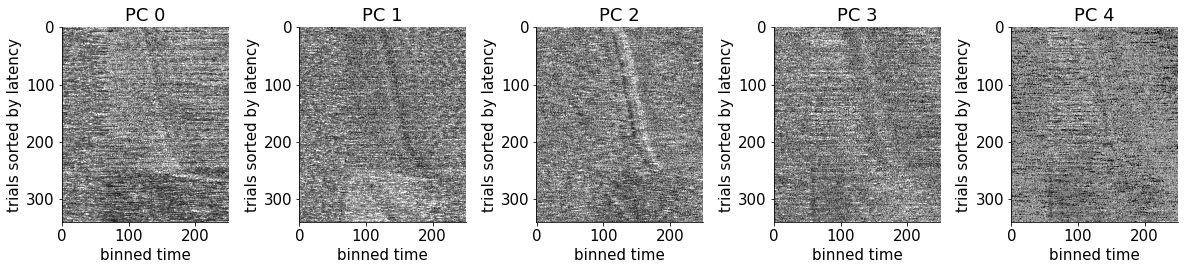

In [11]:
# Now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

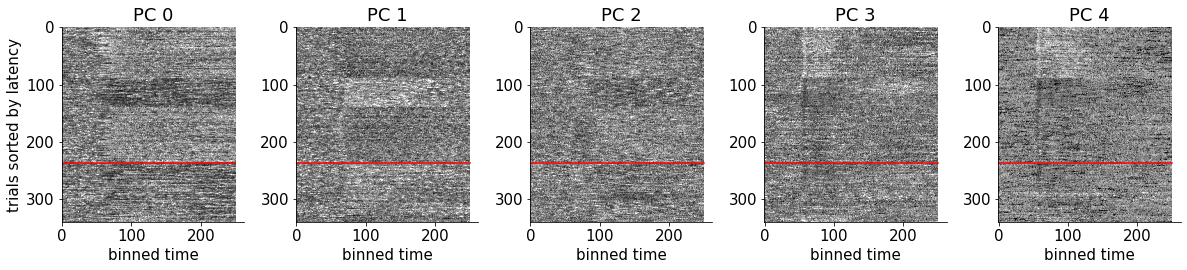

In [ ]:
# Correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect

is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


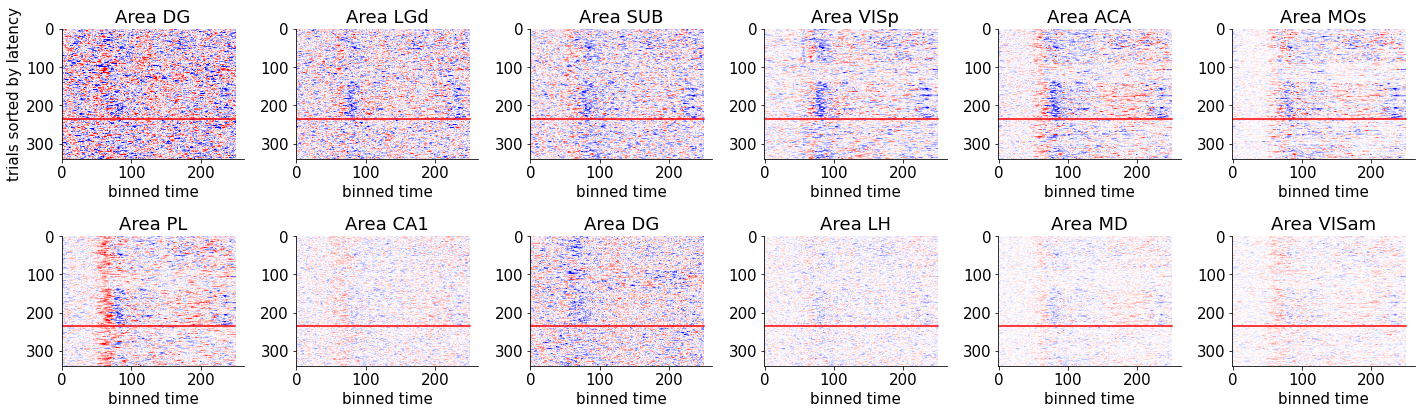

In [ ]:
# plot the LFP

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
isort = np.argsort(-is_correct.astype('float32') + response/10) # sort by correct, and then by response

nwrong = np.sum(is_correct)
plt.figure(figsize=(20,6))
for j in range(len(dat['lfp'])):
  ax = plt.subplot(2,6,j+1)
  plt.imshow(dat['lfp'][j, isort], cmap = 'bwr', vmax = 50, vmin=-50, aspect='auto')
  plt.title('Area %s'%dat['brain_area_lfp'][j])
  
  plt.plot([0, NT], [nwrong, nwrong], 'r')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  


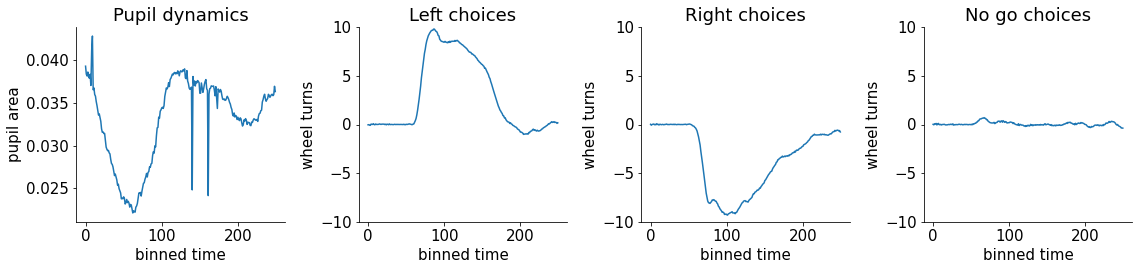

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


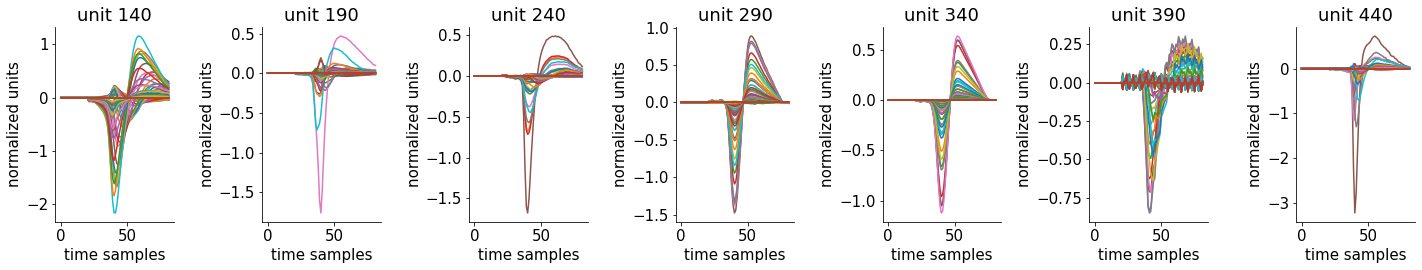

In [ ]:
# plot the spike waveforms for some neurons. Sometimes these can tell us what cell type the neuron is 
# (i.e. fast spiking interneurons have short waveforms)

for j in range(7):
  ax = plt.subplot(1,7,j+1)
  kk = 140 + j * 50
  wav = dat['waveform_w'][kk] @ dat['waveform_u'][kk]
  plt.plot(wav)
  ax.set(xlabel = 'time samples', title ='unit %d'%kk, ylabel = 'normalized units')

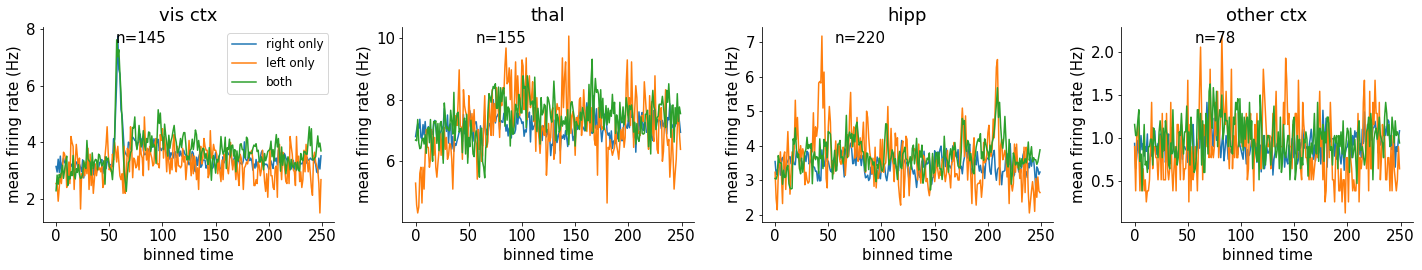

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')